In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
class DataGenerator(object):
    def __init__(self, annFile, dataDir):
        self._annFile = annFile
        self._dataDir = dataDir
        self._coco = COCO(annFile)
        
    def getBatch(self, n=100, imgIds=None, expandMasks=False):
        if imgIds is None:
            ids = self._coco.getImgIds()
            imgIds = ids[:n]
        
        imgs = self._coco.loadImgs(ids=imgIds)

        images = []
        labels = []
        for img in imgs:
            I = io.imread('{}/{}'.format(dataDir, img['file_name']))
            images.append(np.moveaxis(I, -1, 0))
            annIds = self._coco.getAnnIds(imgIds=img['id'])
            anns = self._coco.loadAnns(annIds)
            if expandMasks:
                res = np.zeros((max(self._coco.getCatIds()) + 1,
                                I.shape[0], I.shape[1]))
                for ann in anns:
                    mask = self._coco.annToMask(ann)
                    res[ann['category_id']] = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']])

                labels.append(res)
            else:
                res = np.zeros((I.shape[0], I.shape[1]), dtype=np.int32)
                for ann in anns:
                    mask = self._coco.annToMask(ann) * ann['category_id']
                    res = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']]
                    )
                labels.append(res)

        return images, labels
        

In [3]:
annFile = '../annotations/instances_train2017.json'
dataDir = '../train2017'

In [4]:
gen = DataGenerator(annFile, dataDir)

loading annotations into memory...
Done (t=14.83s)
creating index...
index created!


In [5]:
images, labels = gen.getBatch(50, expandMasks=True)
labels[0].shape

(91, 427, 640)

In [6]:
from torch import nn
from torch.autograd import Variable
import torch
from torchvision import transforms
from PIL import Image
from torchvision.models import vgg19_bn
from torch.nn.functional import conv3d
import itertools

In [7]:
class VGGExtractor(nn.Module):
    def __init__(self):
        super(VGGExtractor, self).__init__()
        model = vgg19_bn(pretrained=True)
        self.first = nn.Sequential(*[model.features[i] for i in range(15)])
        self.second = nn.Sequential(*[model.features[i] for i in range(15, 28)])
        
        for param in model.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        conv3_1 = self.first.forward(x)
        conv4_1 = self.second.forward(conv3_1)
        return conv3_1, conv4_1

In [8]:
trans = VGGExtractor()

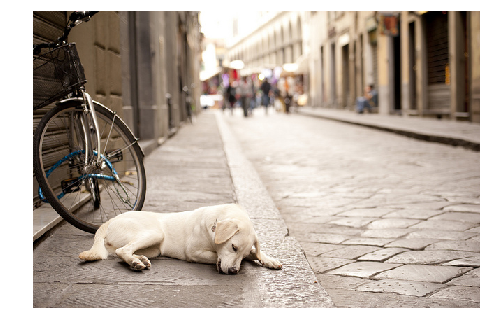

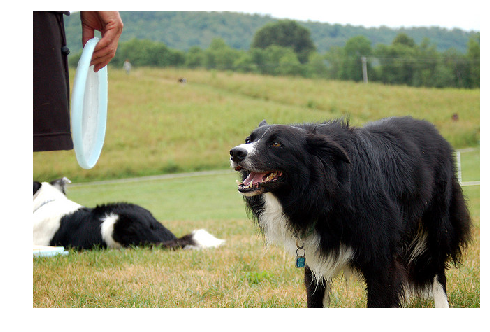

In [9]:
content = images[43]
style = images[2]
plt.figure(1)
plt.axis('off')
plt.imshow(np.moveaxis(content, 0, -1))

plt.figure(2)
plt.axis('off')

plt.imshow(np.moveaxis(style, 0, -1))
plt.show()

content_masks = labels[43]
style_masks = labels[2]
del labels
del images
del gen

In [27]:
def prepare_img(img, requires_grad=False):
    tens = torch.FloatTensor(img)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    tens = transform(tens)
    return Variable(tens.contiguous().view(1, *tens.shape), requires_grad=requires_grad)

In [28]:
gen_img = np.random.randint(0, 255, content.shape, dtype=np.uint8)
gen_var = prepare_img(gen_img, requires_grad=True)

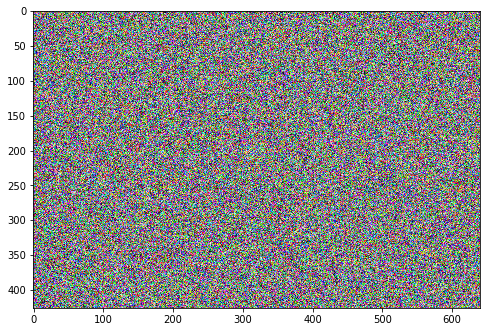

In [29]:
plt.imshow(np.moveaxis(gen_img, 0, -1))
plt.show()

In [30]:
style3_1, style4_1 = trans.forward(prepare_img(style))
cont3_1, cont4_1 = trans.forward(prepare_img(content))

In [31]:
def downsample(imgs, sz):
    """Downsample a sequence of binary images to a given size."""
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(sz),
        transforms.ToTensor(),
    ])
    
    return torch.cat([transform(x.view((1, *x.shape))).view((1, 1, *sz)) for x in imgs], dim=1)
def get_patch(x, j, k, T):
    return x[0, :, j: T + j, k : k + T]

def extract_patches(x, newH, newW, T):
    return torch.cat([get_patch(x, i, j, T).unsqueeze(0) for i, j in itertools.product(range(newH), range(newW))], dim=0)

def get_style_loss(content_masks, style_masks, gen_layer, style_layer):
    T = 3
    s = torch.cat((style_layer, Variable(style_masks, requires_grad=False)), dim=1)
    g = torch.cat((gen_layer, Variable(content_masks, requires_grad=False)), dim=1)
    _, _, H, W = s.shape
    newH, newW = H - T + 1, W - T + 1

    p_s = extract_patches(s, newH, newW, T)
    norm = (((p_s.unsqueeze(1) ** 2).sum(-1).sum(-1)) ** 0.5).unsqueeze(-1).unsqueeze(-1)

    NN = torch.max(conv3d(g.unsqueeze(0), p_s.unsqueeze(1) / norm), 1)[1]
    p_g = extract_patches(g, newH, newW, T)
    p_s = p_s[NN.view(-1)]
    
    return ((p_g - p_s) ** 2).sum()
    

In [32]:
def adjust_lr(optimizer, init_lr, epoch):
    lr = init_lr * (0.3 ** (epoch // 100))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [37]:
import torch.optim as optim
optimizer = optim.Adam([gen_var], lr = 0.5)
for i in range(500):
    adjust_lr(optimizer, 0.9, i)
    optimizer.zero_grad()
    
    gen3_1, gen4_1 = trans.forward(gen_var)
    
    h, w = style3_1.shape[2:]
    BETA = 0.3
    content_masks_3_1 = BETA * downsample(torch.FloatTensor(content_masks), (h, w))
    style_masks_3_1 = BETA * downsample(torch.FloatTensor(style_masks), (h, w))
    h, w = style4_1.shape[2:]
    content_masks_4_1 = BETA * downsample(torch.FloatTensor(content_masks), (h, w))
    style_masks_4_1 = BETA * downsample(torch.FloatTensor(style_masks), (h, w))
    
    style_loss_3_1 = get_style_loss(content_masks_3_1, style_masks_3_1, gen3_1, style3_1)
    style_loss_4_1 = get_style_loss(content_masks_4_1, style_masks_4_1, gen4_1, style4_1)
    
    content_loss = ((cont3_1 - gen3_1) ** 2).sum() + ((cont4_1 - gen4_1) ** 2).sum()
    
    loss = content_loss + style_loss_3_1 + style_loss_4_1
    if i % 30 == 0:
        print("Iteration:", i, "Loss:", loss.data[0])
        print("Content Loss:", content_loss.data[0])
        print("Style Loss 3_1:", style_loss_3_1.data[0])
        print("Style Loss 4_1:", style_loss_4_1.data[0])
    loss.backward()
    optimizer.step()


Iteration: 0 Loss: 91260.296875
Content Loss: 8995.6796875
Style Loss 3_1: 69605.953125
Style Loss 4_1: 12658.6611328125
Iteration: 30 Loss: 92894.5
Content Loss: 8984.93359375
Style Loss 3_1: 70710.3359375
Style Loss 4_1: 13199.234375
Iteration: 60 Loss: 91718.1015625
Content Loss: 8917.59765625
Style Loss 3_1: 69792.28125
Style Loss 4_1: 13008.2294921875
Iteration: 90 Loss: 91354.484375
Content Loss: 8908.1171875
Style Loss 3_1: 69451.1640625
Style Loss 4_1: 12995.2001953125
Iteration: 120 Loss: 90705.8671875
Content Loss: 8896.359375
Style Loss 3_1: 69142.0234375
Style Loss 4_1: 12667.4814453125
Iteration: 150 Loss: 90504.609375
Content Loss: 8901.2919921875
Style Loss 3_1: 68992.734375
Style Loss 4_1: 12610.58203125
Iteration: 180 Loss: 90399.8671875
Content Loss: 8905.65625
Style Loss 3_1: 68904.609375
Style Loss 4_1: 12589.6015625
Iteration: 210 Loss: 90296.4921875
Content Loss: 8899.267578125
Style Loss 3_1: 68832.8046875
Style Loss 4_1: 12564.4208984375
Iteration: 240 Loss: 902

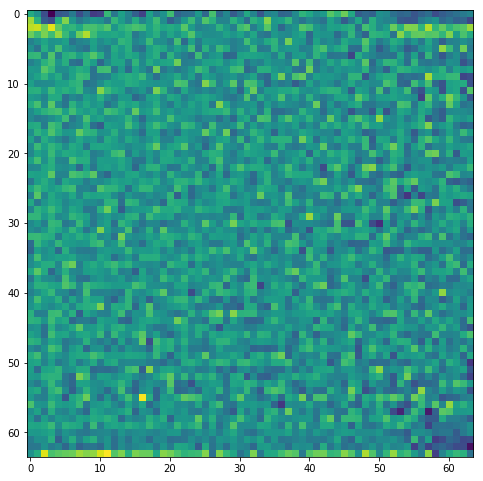

In [39]:
plt.imshow(np.moveaxis(gen_var[0].data[0].numpy().T, 0, -1))
plt.show()